In [11]:
import mmf_setup;mmf_setup.nbinit()
%pylab inline --no-import-all
from nbimports import *

<IPython.core.display.Javascript object>

Populating the interactive namespace from numpy and matplotlib


ModuleNotFoundError: No module named 'nbimports'

# Local Quantum Friction

## Introduction

A common problem with both simulations and experiments is to prepare a quantum system in the ground state.  Experimentally one can usually obtain a good approximation of the ground state by allowing high-energy particles to evaporate at the cost of losing particles.  (The real problem is when one wants to prepare a ground state with a single particle.)  Here we discuss a particular technique useful for finding the ground state of quantum simulations suitable for application to large systems that require high-performance computing (HPC) clusters.

## Fermionic DFT

With simulations, one has a variety of techniques, but with varying computational cost.  The motivation for the method described here is that of finding the ground state in a systems of fermions using density functional theory (DFT).  The state of a fermionic DFT consists of a set of single-particle states $\psi = \{\psi_n\}$.  Each of these single-particle states $\psi_n$ must be orthogonal to each of the others to ensure that the Pauli exclusion principle is satisfied.  (The physical state used in the DFT is a Slater determinant of these "orbitals".)  The challend is that, for larger systems, these states can comprise terrabytes of data, and must be distributed over a HPC cluster.  Most of the minimization techniques destroy the orthogonality of these single-particle states, requireing continual reorthogonalization (i.e. via the Gram-Schmidt process) which communication between all of the compute nodes.  Communication is one of the slowest aspects of computing on a cluster, and this communication effectively prohibits the application of standard minimization techniques for large systems.

In contrast, real-time evolution by applying the Hamiltonian can be efficiently implemented efficiently.  Such evolution 

$$
  \newcommand{\I}{\mathrm{i}}
  \newcommand{\d}{\mathrm{d}}
  \newcommand{\vect}[1]{\vec{#1}}
  \newcommand{\op}[1]{\hat{#1}}
  \newcommand{\abs}[1]{\lvert#1\rvert}
  \newcommand{\pdiff}[2]{\frac{\partial #1}{\partial #2}}
  \newcommand{\ket}[1]{\lvert#1\rangle}
  \newcommand{\bra}[1]{\langle#1\rvert}
  \newcommand{\braket}[1]{\langle#1\rangle}
  \DeclareMathOperator{\Tr}{Tr}
  \I \hbar\pdiff{\psi_n}{t} = \op{H}\psi_n.
$$

requires communicating the same Hamiltonian $\op{H}[\{\psi_n\}]$ to each of the nodes, but this typically only requires sending the effective potential - the equivalent of a single wavefunction of information - to each of the nodes which is feasible for large states.  (Technically, this is computed by a single reduce operation over the cluster.)

The method of local quantum friction discussed here provides real-time evolution with a modified Hamiltonian $\op{H}_f$ so as to remove energy from the system while maintaining orthonormality of the single-particle states.  We shall demonstrate this technique here using bosons simulated with the GPE.  Since the bosonic DFT depends on a single wavefunction (sometimes called an "orbital free" DFT), one has access to the other techniques, but we proceed keeping the fermionic example in mind.

## Formulation

Consider the GPE: the ground state can be defined as a constrained variation of an energy functional $E[\psi]$ while fixing the particle number $N[\psi]$.  The variational condition defines the time-evolution of the system:

$$
  \I \hbar\pdiff{\psi}{t} 
  = (\op{H}[\psi] - \mu)\psi
  = \pdiff{(E[\psi] - \mu N[\psi])}{\psi^\dagger},\\
  E[\psi] = \int \d^3\vect{x}\left(
    \frac{\hbar^2\abs{\vect{\nabla}\psi}^2}{2m} 
    + \frac{g}{2}n^2(\vect{x})
    + V(\vect{x})n(\vect{x})
  \right),
  \qquad
  N[\psi] = \int \d^3{x}\; n(\vect{x}),\\
  n(\vect{x}) = \abs{\psi(\vect{x})}^2.
$$

This gives rise to the usual GPE effective Hamiltonian:

$$
  \op{H}[\psi] = \frac{-\hbar^2\nabla^2}{2m} + gn(\vect{x}) + V(\vect{x}).
$$

### Imaginary Time Cooling

The most straight-forward approach to the minimization problem is the method of steepest descent - going downhill:

$$
  \d \psi \propto -\pdiff{E[\psi]}{\psi^\dagger} \propto - \op{H}\psi.
$$

*Note: There is a slight subtlety here since we are minimizing a function of a complex field $\psi$.  A careful treatment breaking $\psi$ into real and imaginary parts coupled with the fact that the energy is a real symmetric function $E[\psi^\dagger, \psi] = E[\psi, \psi^\dagger]$ shows that $\d{\psi} \propto -\partial{E}/\partial{\psi^\dagger}$ indeed gives the correct descent diretion.*

Thus, we can implement a continuous gradient descent if we evolve

$$
  \hbar\pdiff{\psi}{\tau} = - \op{H}\psi = - \I\hbar \pdiff{\psi}{t}
$$

with respect $\tau = -\I t$ which is equivalent to our original evolution with respect to an "imaginary time" $t = \I \tau$.  Mathematically, this can be expressed by including a "cooling phase" in front of the evolution:

$$
  e^{\I\phi} \I\hbar \pdiff{\psi}{t} = \op{H}\psi.
$$

Real-time evolution is implemented when $e^{\I \phi} = 1$, while imaginary-time cooling is implemented when $e^{\I\phi} = \I$.  Complex-time evolution with $e^{\I\phi} \propto 1 + \epsilon \I$ can be used to mimic superfluid dynamics with dissipation.  This is implemented in the simulations through the cooling parameter $\epsilon$.  Imaginary time cooling is realized with large values of $\epsilon$.

Directly implementing evolution with an imaginary component to the phase will not only reduce the energy, but will also reduce the particle number.  Generally this is not desirable, so we must rescale the wave-function to restore the particle number.  Scaling the wavefunction $\psi \rightarrow s(t)\psi$ corresponds to a term in the evolution $\partial \psi/\partial t \propto s'(t)\psi$.  This can be implemented by adding a constant to Hamiltonian, aka a chemical potential:

$$
  e^{\I\phi} \I\hbar \pdiff{\psi}{t} = (\op{H} - \mu)\psi.
$$

A little investigation shows that one should take:

$$
  \mu(t) = \frac{\braket{\psi|\op{H}|\psi}}{\braket{\psi|\psi}}.
$$

Expressed in another way, we make the change in the state $\ket{\d\psi} \propto \op{H}\ket{\psi}$ orthogonal to $\ket{\psi}$ so that the state simply "rotates" without changing length:

$$
  \ket{\d\psi} \propto (\op{H} - \mu)\ket{\psi}, \qquad \braket{\d\psi|\psi} = 0.
$$

This immediately gives the condition $\mu = \braket{\op{H}}$ given above, which will preserve the normalization of the state no-matter what the cooling phase.  *Incidentally, even if one performs real-time evolution, using such a chemical potential can be numerically advantageous as it minimizes the phase evolution of the state.  This has not physical significance, but reduces numerical errors and allows one to use larger time-steps.*

### Example 1: Cooling

Run the following simulation of a highly-excited superfluid and explore the effect of the cooling phase.  The simulation starts with a BEC in a cylindrical trap rotating with a high angular velocity.  You can addjust the cooling parameter $\epsilon$ with the first slider.  For large amounts of cooling, you should see the system rapidly lose energy to form a set of orbiting vortices.

In [7]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) { return false; }

<IPython.core.display.Javascript object>

In [8]:
# Does not work on CoLab yet
from mmf_setup.set_path import hgroot
from importlib import reload
#from super_hydro.client import notebook;reload(notebook)
#notebook.run(model='gpe.BEC', Nx=64, Ny=64)

### Quantum Friction

One can derive cooling from another perspective which allows the desired generalization.  Consider how the energy of the system $E[\psi]$ changes when we evolve the system with a "cooling" Hamiltonian $\op{H}_c = \op{H}_c^\dagger$, which we restrict:

$$
  \I\hbar \ket{\dot{\psi}} \equiv \I\hbar \pdiff{\ket{\psi}}{t}
  = \op{H}_{c}\ket{\psi}.
$$

The change in the energy is:

\begin{align}
  \dot{E} &= \bra{\dot{\psi}}\pdiff{E}{\bra{\psi}} + \pdiff{E}{\ket{\psi}}\ket{\dot{\psi}},\\
          &= \braket{\dot{\psi}|\op{H}|\psi} + \braket{\psi|\op{H}|\dot{\psi}},\\
          &= \frac{-\braket{\psi|\op{H}_c\op{H}|\psi} + \braket{\psi|\op{H}\op{H}_c|\psi}}{\I\hbar}
          = \frac{\braket{\psi|[\op{H},\op{H}_c]|\psi}}{\I\hbar}.
\end{align}

If we can choose $\op{H}_c$ to ensure that the last term is negative-definite, then we have a cooling procedure.  The last term can be more usefully expressed in terms of the normalized density operator $\op{R} = \ket{\psi}\bra{\psi}/\braket{\psi|\psi}$ and using the cyclic property of the trace:

$$
  \frac{\braket{\psi|[\op{H},\op{H}_c]|\psi}}{\braket{\psi|\psi}} 
  = \Tr\left(\op{R}[\op{H},\op{H}_c]\right)
  = \Tr\left(\op{H}_c[\op{R},\op{H}]\right),\qquad
  \hbar\dot{E} = -\braket{\psi|\psi}\Tr\left(\I[\op{R},\op{H}]\op{H}_c\right).
$$

This gives the optimal choice:

$$
  \op{H}_c = \left(\I[\op{R},\op{H}]\right)^{\dagger}
           = \I[\op{R},\op{H}], \qquad
  \hbar\dot{E} = -\braket{\psi|\psi}\Tr(\op{H}_c^\dagger\op{H}_c),
$$

ensuring a continuous steepest descent.  It turns out that this choice is equivalent to imaginary time cooling with rescaling:

$$
  \op{H}_c = \frac{-\I}{\braket{\psi|\psi}}
  (\op{H}\ket{\psi}\bra{\psi}-\ket{\psi}\bra{\psi}\op{H})\\
  \I\ket{\dot{\psi}} = \op{H}_c\ket{\psi} 
  = -\I\left(
    \op{H} - \frac{\braket{\psi|\op{H}|\psi}}{\braket{\psi|\psi}}
  \right)\ket{\psi}
  = -\I(\op{H} - \mu)\ket{\psi}.
$$

*One can include an arbitrary real constant in $\op{H}_c$ but this just amounts to rescaling $t$.  It might be tempting to include a large constant so that the energy decreases rapidly, but then one will need to take correspondingly smaller time-steps exactly negating the effect.*

*From now on, we will assume our states are properly normalized, dropping the factors of $\braket{\psi|\psi} = 1$.*

### Fermions

Now consider the same approach for cooling an orbital based DFT (Hatree-Fock) whose states are formed as a Slater determinant of $N$ orthonormal single-particle states $\ket{\psi_n}$ where $\braket{\psi_m|\psi_n} = \delta_{mn}$.  In this case, the density matrix has the form:

$$
  \op{R} = \sum_{n}\ket{\psi_n}\bra{\psi_n}.
$$

The same formulation applies with maximal cooling being realized for $\op{H}_c = \I[\op{R},\op{H}]$ so that

$$
  \op{H}_c\ket{\psi_i} = -\I\sum_{n}\left(
    \op{H}\ket{\psi_n}\braket{\psi_n|\psi_i}
    -
    \ket{\psi_n}\braket{\psi_n|\op{H}|\psi_i}
  \right)
  = -\I\left(
    \op{H}\ket{\psi_i}
    -
    \sum_{n}\ket{\psi_n}\braket{\psi_n|\op{H}|\psi_i}
  \right).
$$

This again amounts to imaginary time evolution with $\op{H}$ plus additional corrections to ensure that the evolution maintains the orthonormality of the single-particle states $\braket{\psi_m|\psi_n} = \delta_{mn}$ (effecting a continuous Gram-Schmidt process). It is clear that overlaps between all states $H_{ni}=\braket{\psi_n|\op{H}|\psi_i}$ must be computed, making this approach expensive in terms of communication.

*As before, we will now assume that all single-particle states are orthonormal $\braket{\psi_m|\psi_n} = \delta_{mn}$.*

### Local Formulation

Instead, one can use the same formalism, but consider alternative forms of $\op{H}_c$ that are easier to compute.  In particular, one can consider local operators in position or momentum space:

$$
  \op{H}_c = \beta_K\op{K}_c + \beta_V\op{V}_c
$$

where $\op{V}_c$ is a potential diagonal in position space $\braket{x|\op{V}_c|x} = V_c(x)$ and $\op{K}_c$ is "potential" diagonal in momentum space $\braket{k|\op{K}_c|k} = K_c(k)$:

$$
  \op{K}_c = \int\frac{\d{k}}{2\pi}\;\ket{k}K_c(k)\bra{k}, \qquad
  \op{V}_c = \int\d{x}\;\ket{x}V_c(x)\bra{x}.
$$

Proceeding as before, we can assure that the energy decreases if

\begin{gather}
  \hbar \dot{E} = -\I\Tr(\op{H}_c[\op{R}, \op{H}]) \leq 0\\
  \begin{aligned}
    V_c(x) &= \I\braket{x|[\op{R},\op{H}]|x} 
           = \hbar \dot{n}(x), &
    K_c(k) &= \I\braket{k|[\op{R},\op{H}]|k}
           = \hbar\dot{n}(k),
  \end{aligned}
\end{gather}

where the time-derivatives are taken with respect to evolution with the original Hamiltonian:

$$
  \hbar\dot{n}(x) = \hbar\braket{x|\dot{\op{R}}|x} 
                  = -\I\braket{x|[\op{H},\op{R}]|x}, \qquad
  \hbar\dot{n}(k) = \hbar\braket{k|\dot{\op{R}}|k} 
                 = -\I\braket{k|[\op{H},\op{R}]|k}.
$$

*If the Hamiltonian separates $\op{H} = \op{K} + \op{V}$ into pieces that are local in momentum and position space respectively, then we can simplify these:*

$$
  \braket{x|[\op{R},\op{H}]|x} = \braket{x|[\op{R},\op{K}]|x},
  \qquad
  \braket{k|[\op{R},\op{H}]|k} = \braket{k|[\op{R},\op{V}]|k}.
$$

The meaning of these "cooling" potential is elucidated by considering the continuity equation:

$$
  \dot{n}(x) = -\vect{\nabla}\cdot\vect{j}(x) \propto V_c(x).
$$

The if the density is increasing at $x$ due to converging current, then the cooling potential will increase at this point to slow the converging flow, thereby removing kinetic energy from the system.  The interpretation for $V_K(k)$ is similar in the dual space, though less conventional.

Here are some explicit formulae:

$$
  V_c(x) = 2\Im\Bigl(\psi^*(x)\braket{x|\op{K}|\psi}\Bigr)
         = 2\Im\Bigl(\psi^*(x)\braket{x|\op{H}|\psi}\Bigr),\qquad
  K_c(k) = 2\Im\Bigl(\psi^*(k)\braket{k|\op{V}|\psi}\Bigr)
         = 2\Im\Bigl(\psi^*(k)\braket{k|\op{H}|\psi_}\Bigr).
$$

Thus, we can simply apply the original Hamiltonian $\op{H}$ to $\ket{\psi}$ and consider the diagonal pieces in position and momentum space.  In the fermionic cases, these would need to be summed over all single-particle wave-functions.

$$
  V_c(x) = \sum_i 2\Im\Bigl(\psi_i^*(x)\braket{x|\op{K}|\psi_i}\Bigr),\qquad
  K_c(k) = \sum_i 2\Im\Bigl(\psi_i^*(k)\braket{k|\op{V}|\psi_i}\Bigr).
$$


#### Normalization

To properly normalize these, we decompose $\op{H}_c$ into an orthonormal basis of operators with [Frobenius inner product](https://en.wikipedia.org/wiki/Frobenius_inner_product):

$$
  \braket{\op{A}, \op{B}}_F = \frac{1}{N}\Tr(\op{A}^\dagger\op{B}).
$$

This is motivated by the condition that minimizing the energy requires

$$
  \hbar\dot{E} = -\Tr\left(\I[\op{R},\op{H}]\op{H}_c\right)
               = -\braket{\I[\op{R},\op{H}], \op{H}_c}_F \leq 0.
$$

Thus, given an orthonormal basis, we can take any linear combination of the components of $\I[\op{R},\op{H}]$ in that basis with **positive real coefficients** and we will obtain a cooling Hamiltonian.

To properly normalize the states, consider the following relationships expressed in terms of a box of length $L$ with $N$ lattice points $x_n = na$ where $a=L/N \equiv \d{x}$ is the lattice spacing, and the wave-numbers are $k_n = 2\pi n/L$ with spacing $\d{k} \equiv 2\pi / L$.  We use the position basis $\ket{x}$ and momentum basis $\ket{k}$ with the following normalizations (continuum on the left, discrete on the right):

\begin{align}
  \op{1} = \int\d{x}\;\ket{x}\bra{x} 
  &\equiv
  \frac{L}{N}\sum_n \ket{x_n}\bra{x_n},
  &
  \op{1} = \int \frac{\d{k}}{2\pi}\;\ket{k}\bra{k}
  &\equiv
  \frac{1}{L}\sum_n \ket{k_n}\bra{k_n},\\
  \braket{x_m|x_n} = \delta(x_m-x_n) 
  &\equiv \frac{1}{\d{x}}\delta_{mn} = \frac{N}{L}\delta_{mn}, 
  &
  \braket{k_m|k_n} = (2\pi)\delta(k_m-k_n) 
  &\equiv \frac{2\pi}{\d{k}}\delta_{mn} = L\delta_{mn}.
\end{align}

The overlaps and discrete Fourier transforms implemented numerically compute the following:

\begin{align}
  \DeclareMathOperator{\FFT}{FFT}
  \braket{x_m|k_n} = e^{\I x_m k_n} 
  &\equiv e^{2\pi\I m n/N},\\
  \FFT[\psi](k_m)
  = \frac{\braket{k_m|\psi}}{\d{x}}
  = \frac{1}{\d{x}}\int\d{x} \braket{k_m|x}\braket{x|\psi}
  = \frac{N}{L}\int\d{x} e^{-\I x k_m}\psi(x)
  &\equiv
  \sum_{n} e^{-2\pi \I nm/N}\psi(x_n),\\
  \FFT^{1}[\psi](x_n)
  = \d{x}\braket{x_n|\psi}
  = \d{x}\int\frac{\d{k}}{2\pi}\; \braket{x_n|k}\braket{k|\psi}
  = \frac{L}{N}\int\frac{\d{k}}{2\pi}\; e^{\I x_n k}\tilde{\psi}(k)
  &\equiv
  \frac{1}{N}\sum_{m} e^{2\pi \I n m / N}\tilde{\psi}(k_m).
\end{align}


In [9]:
import numpy as np
N = 4
L = 10.0
dx = L/N
x = np.arange(N)*dx
k = 2*np.pi * ((np.arange(N) + N//2) % N - N//2) / L
assert np.allclose(k, 2*np.pi * np.fft.fftfreq(N, dx))
np.random.seed(2)
psi = np.random.random(N) + 1j*np.random.random(N) - 0.5 - 0.5j
psi_k = np.exp(-1j*k[:, None]*x[None, :]).dot(psi)
psi_ = np.exp(1j*k[None, :]*x[:, None]).dot(psi_k)/N
assert(np.allclose(psi_k, np.fft.fft(psi)))
assert(np.allclose(psi_, np.fft.ifft(psi_k)))

With these normalizations, we have the following basis matrices for the space of operators diagonal in position and momentum space:

$$
  \op{1}, \qquad
  \op{V}_x = \frac{L}{\sqrt{N}}\ket{x}\bra{x}, \qquad
  \op{K}_k = \frac{\sqrt{N}}{L}\ket{k}\bra{k},\\
  \braket{\op{V}_{x_m}, \op{V}_{x_n}}_F = 
  \braket{\op{K}_{k_m}, \op{K}_{k_n}}_F = \delta_{mn}, \qquad
  \braket{\op{I}, \op{I}}_F = 1.  
$$

This gives the following normalizations:

$$
  \op{V}_c = \int \d{x}\;\ket{x}V_c(x)\bra{x}, \qquad
  V_c(x) = \I\frac{L}{N}\braket{x|[\op{R},\op{H}|x}
         = 2\d{x}\Im\frac{\psi^*(x)[H\psi](x)}{N_{tot}}
         = \hbar \d{x} \frac{\dot{n}(x)}{\braket{\psi|\psi}},\\
  \op{K}_c = \int \frac{\d{k}}{2\pi}\;\ket{k}K_c(k)\bra{k}, \qquad
  K_c(k) = \I\frac{1}{L}\braket{k|[\op{R},\op{H}|k}
         = 2\Im\frac{\psi^*(k)[H\psi](k)}{N_{tot} L}
         = \hbar\frac{\dot{n}_{k}}{L N_{tot}}
$$

where $\psi(k) = \braket{k|\psi} = \d{x} \FFT(\psi)$.

$$
  \op{V}_c = \int \d{x}\;\ket{x}V_c(x)\bra{x}, \qquad
  V_c(x) = \hbar \d{x} \frac{\dot{n}(x)}{N_{tot}},\\
  \op{K}_c = \int \frac{\d{k}}{2\pi}\;\ket{k}K_c(k)\bra{k}, \qquad
  K_c(k) = \hbar\frac{\dot{n}_{k}}{L N_{tot}}
$$



Note: to formally make the bases $\op{V}_x$ and $\op{K}_k$ orthogonal, we should subtract off the common component of the identity:

$$
  \op{V}_x = \frac{L\ket{x}\bra{x} - \op{1}}{\sqrt{N-1}}, \qquad
  \op{K}_k = \frac{\frac{N}{L}\ket{k}\bra{k} - \op{1}}{\sqrt{N-1}},\qquad
  \braket{\op{V}_x, \op{K}_k}_F = 0.
$$

## Departure from Locality

We can generalize these operators slightly to cool in a non-local fashion.  For example, consider the following cooling Hamiltonian.  (The motivation here is that the operators $\op{D}$ are derivatives, so this Hamiltonian is quasi-local.)

$$
  \op{H}_c = \int \d{x}\; \op{D}_a^\dagger\ket{x}V_{ab}(x)\bra{x}\op{D}_b + \text{h.c.},\\
  \hbar \dot{E} = -\I\left(
    \int\d{x}\;V_{ab}(x)
    \braket{x|\op{D}_b[\op{R},\op{H}]\op{D}_a^\dagger|x}
    + \text{h.c.}
  \right).
$$

We can ensure cooling if we take:

$$
  \hbar V_{ab}(x) 
  = (\I\hbar\braket{x|\op{D}_b[\op{R},\op{H}]\op{D}_a^\dagger|x})^*
  = \I\hbar\braket{x|\op{D}_a[\op{R},\op{H}]\op{D}_b^\dagger|x}\\
  = \braket{x|\op{D}_a|\psi}\braket{x|\op{D}_b|\dot{\psi}}^*
  + \braket{x|\op{D}_a|\dot{\psi}}\braket{x|\op{D}_b|\psi}^*.
$$

If $\op{D}_{a,b}(x)$ are just derivative operators $\braket{x|\op{D}_{a}|\psi} = \psi^{(a)}(x)$, then we have

$$
  \hbar V_{ab}(x) 
  = \psi^{(a)}(x)\overline{\dot{\psi}^{(b)}(x)}
  + \dot{\psi}^{(a)}(x)\overline{\psi^{(b)}(x)},
$$

where

$$
  \dot{\psi}(x) = -\I\hbar\braket{x|\op{H}|\psi}
$$

is the time-derivative with respect to the original Hamiltonian.  Note that these "potentials" are no longer diagonal in either momentum or position space, so they should be implemented in the usual fashion with an integrator like ABM.

### Aurel's Notes

In Aurel's notes, he considers:

\begin{align}
  V_0(x) &= 2V_{00}(x) = \sum_{n}\left(
    \psi_n(x)\dot{\psi}_n^*(x) + \dot{\psi}_n(x)\psi_n^*(x)
  \right)
  = \sum_{n} \pdiff{\psi_n(x)\psi_n^*(x)}{t}
  = \sum_{n} \dot{n}_n(x), \\
  \vect{V}_1(x) &= V_{0i}(x) 
    = \sum_{n}\left(
      \psi_n(x)\vect{\nabla}\dot{\psi}_n^*(x)
      + \dot{\psi}_n(x)\vect{\nabla}\psi_n^*(x)\right)
    = \sum_{n}\pdiff{}{t}\left(
      \psi_n(x)\vect{\nabla}\psi_n^*(x)\right)\\
  \overleftrightarrow{V_2}(x) &= V_{ij}(x)
    = \sum_{n}\left(
      \overleftarrow{\nabla}\psi_n(x)\overrightarrow{\nabla}\dot{\psi}_n^*(x)
      + \overleftarrow{\nabla}\dot{\psi}_n(x)\overrightarrow{\nabla}\psi_n^*(x)\right)  
    = \sum_{n}\pdiff{}{t}\left(
      \overleftarrow{\nabla}\psi_n(x)\overrightarrow{\nabla}\psi_n^*(x)
\right)\\  
\end{align}

# Explicit Demonstration

Here we provide an explicit demonstration with a 1D or 2D BEC in a box.  We start with a simple class that uses the split-operator evolution method to evolve with:

$$
  \op{H}_c = \beta_0 \op{H} + \beta_V \op{V}_c + \beta_K \op{K}_c.
$$

At each step we renormalize the state, so if $\beta = -\I$, then imaginary time evolution is implemented with $\op{H}_c = \I[\op{R}, \op{H}] + \cdots$.  This is not the most efficient implementation (excessive FFT calls are made) but the structure should be clear.  Following this, we implement a standard integrator that can deal with the non-local extensions.

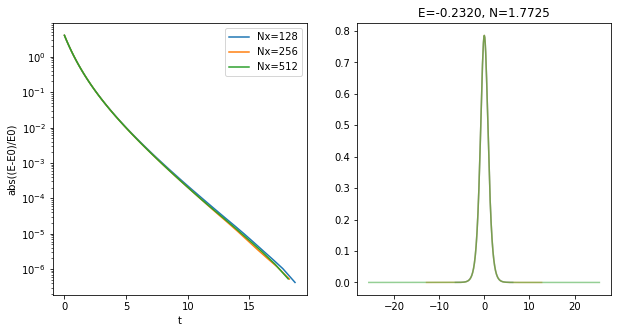

In [12]:
from mmf_setup.set_path import hgroot
from super_hydro.contexts import NoInterrupt
from IPython.display import clear_output
from importlib import reload
import quantum_friction;reload(quantum_friction)

from quantum_friction import StateBase

plt.figure(figsize=(10,5))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
for Nx in [128, 256, 512]:
    s = StateBase(Nxyz=(Nx,), beta_0=-1j)
    s.g = -1
    r2 = sum(_x**2 for _x in s.xyz)
    psi_0 = s.zero + np.exp(-r2/2.0)*np.exp(1j*s.xyz[0])

    ts, psis = s.solve(psi_0, T=20, rtol=1e-5, atol=1e-6, method='BDF')
    psi0 = psis[-1]
    E0, N0 = s.get_E_N(psi0)
    Es = [s.get_E_N(_psi)[0] for _psi in psis]

    line, = ax1.semilogy(ts[:-2], (Es[:-2] - E0)/abs(E0), label=f"Nx={Nx}")
    plt.sca(ax2)
    s.plot(psi0, c=line.get_c(), alpha=0.5)

plt.sca(ax1)
plt.legend()
plt.xlabel('t')
plt.ylabel('abs((E-E0)/E0)');

This demonstrates that for a bright soliton, imaginary time cooling cools at the same rate, independent of the box size.

In [ ]:
from mmf_setup.set_path import hgroot
from super_hydro.contexts import NoInterrupt
from IPython.display import clear_output
from importlib import reload
import quantum_friction;reload(quantum_friction)

from quantum_friction import StateBase

plt.figure(figsize=(10,5))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
for Nx in [128, 256, 512]:
    s = StateBase(Nxyz=(Nx,), beta_0=-1j)
    s.g = 1
    r2 = sum(_x**2 for _x in s.xyz)
    x = s.xyz[0]
    psi_0 = np.sqrt(1.0 + s.zero + 0.2*x*np.exp(-r2))

    ts, psis = s.solve(psi_0, T=2, rtol=1e-5, atol=1e-6, method='BDF')
    psi0 = psis[-1]
    E0, N0 = s.get_E_N(psi0)
    Es = [s.get_E_N(_psi)[0] for _psi in psis]

    line, = ax1.semilogy(ts[:-2], Es[:-2] - E0, label=f"Nx={Nx}")
    plt.sca(ax2)
    s.plot(psi_0, c=line.get_c(), alpha=0.5)
    s.plot(psi0, c=line.get_c(), alpha=0.5)
    
plt.sca(ax1)
plt.legend()
plt.xlabel('t')
plt.ylabel('E-E0');

In [ ]:
np.random.seed(2)
psi = s.unpack(np.random.random(2*np.prod(s.Nxyz)) - 0.5)
Vc = s.get_Vc(psi)
Kc = s.get_Kc(psi)
Hc = s.get_Hc(psi)
#np.diag(Hc) - Vc
Hc_k = np.fft.ifft(np.fft.fft(Hc, axis=0), axis=1)
np.diag(Hc_k).real - Kc

In [ ]:
reload(quantum_friction)
from quantum_friction import StateBase
s = StateBase(Nxyz=(32, 32), beta_0=-1.0j, beta_V=0.0, beta_K=0.0)
#s = StateBase(Nxyz=(32, 32), beta_0=-1j)
x, y = s.xyz
x0 = 0.5
phase = ((x-x0) + 1j*y)*((x+x0) - 1j*y)
psi0 = 1.0*np.exp(1j*np.angle(phase))
ts, psis = s.solve(psi0, T=1.0, rtol=1e-5, atol=1e-6)
display(s.plot(psis[-1]));


In [ ]:
NoInterrupt.unregister()
with NoInterrupt() as interrupted:
    for t, psi in zip(ts, psis):
        if interrupted:
            break
        plt.clf()
        display(s.plot(psi))
        print(t)
        clear_output(wait=True)

In [ ]:
    def step(self, psi, n=1):
        """Evolve the state psi by applying n steps of the 
        Split-Operator method."""
        psi = self.apply_expK(psi, factor=0.5)
        for n in range(n):
            psi = self.apply_expV(psi)
            psi = self.apply_expK(psi)
        psi = self.apply_expK(psi, factor=-0.5)
        return psi

    def apply_expK(self, psi, factor=1):
        psi_k = np.fft.fft(psi)
        Kc = self.get_Kc(psi=psi)
        K = self.beta_0*self._K2 + self.beta_K*Kc
        psi_new = np.fft.ifft(np.exp(-1j*self.dt*factor*K) * psi_k)
        psi_new *= np.sqrt((abs(psi)**2).sum()
                           / (abs(psi_new)**2).sum())
        return psi_new
        
    def apply_expV(self, psi, factor=1):
        Vc = self.get_Vc(psi)
        n = self.get_density(psi)
        V0 = self.get_V(psi)
        V = self.beta_0*V0 + self.beta_V*Vc
        psi_new = np.exp(-1j*self.dt*factor*V) * psi
        psi_new *= np.sqrt((abs(psi)**2).sum()
                           / (abs(psi_new)**2).sum())
        return psi_new

    def get_V(self, psi):
        """Return the complete potential included g*n."""
        n = self.get_density(psi)
        return self.g*n
    
    def get_Vc(self, psi):
        n = self.get_density(psi)
        psi_k = np.fft.fft(psi)
        Kpsi = np.fft.ifft(self._K2*psi_k)
        Vc = 2*(psi.conj()*Kpsi).imag / n.sum()
        return Vc

    def get_Kc(self, psi):
        n = self.get_density(psi)
        N = n.sum()*self.dx
        psi_k = np.fft.fft(psi)*self.dx
        V = self.get_V(psi)
        Vpsi_k = np.fft.fft(V*psi)*self.dx
        Kc = 2*(psi_k.conj()*Vpsi_k).imag / self.L / n.sum()
        return Kc

    def get_E_N(self, psi):
        """Return the energy and particle number `(E,N)`."""
        dx = self.dx
        n = self.get_density(psi)
        K = abs(np.fft.ifft(self.hbar*self.k*np.fft.fft(psi)))**2/2/self.m
        E = ((self.g*n**2/2 + K).sum()*dx).real
        N = n.sum()*dx
        return E, N
    
    def plot(self, psi):
        plt.clf()
        plt.subplot(121)
        plt.plot(self.x, abs(psi)**2)
        plt.ylim(0,2)
        plt.twinx()
        Vc = self.get_Vc(psi)
        plt.plot(self.x, Vc, 'C1')
        Kc = self.get_Kc(psi)
        y = abs(np.fft.ifft(Kc)*len(self.x))**2
        plt.plot(self.x, y, 'C2')
        E, N = self.get_E_N(psi)
        plt.suptitle(f"E={E:.4f}, N={N:.4f}")
        return plt.gcf()

    def _plot(self, psi):
        plt.clf()
        plt.plot(self.x, abs(psi)**2)
        plt.ylim(0,2)
        plt.twinx()
        Kc = self.get_Kc(psi)
        y = np.fft.ifft(Kc)
        print(abs(y.real).max(), abs(y.imag).max())
        y /= abs(y).max()
        plt.plot(self.x, y.real, 'C2')
        plt.ylim(-1,1)
        E, N = self.get_E_N(psi)
        plt.suptitle(f"E={E:.4f}, N={N:.4f}")
        return plt.gcf()
    

In [ ]:
%pylab inline --no-import-all
import numpy as np
class CoolingEg(object):
    g = hbar = m = 1.0
    def __init__(self, beta_0=1.0, beta_V=1.0 ,beta_K=1.0, 
                 N=256, dx=0.1,
                 dt_Emax=1.0):
        """
        Arguments
        ---------
        beta_0 : complex
           Portion of the original Hamiltonian H to include in evolution.
           Make -1j for imaginary time cooling.
        beta_V : float
           Portion of the position cooling potential V_c.
        beta_K : float
            Portion of the momentum cooling potential K_c.
        """
        self.N = N
        self.dx = dx
        self.L = dx*N
        self.x = np.arange(N)*dx - self.L/2
        self.k = 2*np.pi * np.fft.fftfreq(N, dx)
        self.beta_0 = beta_0
        self.beta_V = beta_V
        self.beta_K = beta_K
        
        # Pre-compute the kinetic energy
        self._K2 = (self.hbar*self.k)**2/2/self.m
        self.Emax = self._K2.max()
        self.dt = dt_Emax * self.hbar/self.Emax

    def step(self, psi, n=1):
        """Evolve the state psi by applying n steps of the 
        Split-Operator method."""
        psi = self.apply_expK(psi, factor=0.5)
        for n in range(n):
            psi = self.apply_expV(psi)
            psi = self.apply_expK(psi)
        psi = self.apply_expK(psi, factor=-0.5)
        return psi

    def get_density(self, psi):
        return abs(psi)**2
    
    def apply_expK(self, psi, factor=1):
        psi_k = np.fft.fft(psi)
        Kc = self.get_Kc(psi=psi)
        K = self.beta_0*self._K2 + self.beta_K*Kc
        psi_new = np.fft.ifft(np.exp(-1j*self.dt*factor*K) * psi_k)
        psi_new *= np.sqrt((abs(psi)**2).sum()
                           / (abs(psi_new)**2).sum())
        return psi_new
        
    def apply_expV(self, psi, factor=1):
        Vc = self.get_Vc(psi)
        n = self.get_density(psi)
        V0 = self.get_V(psi)
        V = self.beta_0*V0 + self.beta_V*Vc
        psi_new = np.exp(-1j*self.dt*factor*V) * psi
        psi_new *= np.sqrt((abs(psi)**2).sum()
                           / (abs(psi_new)**2).sum())
        return psi_new

    def get_V(self, psi):
        """Return the complete potential included g*n."""
        n = self.get_density(psi)
        return self.g*n
    
    def get_Vc(self, psi):
        n = self.get_density(psi)
        psi_k = np.fft.fft(psi)
        Kpsi = np.fft.ifft(self._K2*psi_k)
        Vc = 2*(psi.conj()*Kpsi).imag / n.sum()
        return Vc

    def get_Kc(self, psi):
        n = self.get_density(psi)
        N = n.sum()*self.dx
        psi_k = np.fft.fft(psi)*self.dx
        V = self.get_V(psi)
        Vpsi_k = np.fft.fft(V*psi)*self.dx
        Kc = 2*(psi_k.conj()*Vpsi_k).imag / self.L / n.sum()
        return Kc

    def get_E_N(self, psi):
        """Return the energy and particle number `(E,N)`."""
        dx = self.dx
        n = self.get_density(psi)
        K = abs(np.fft.ifft(self.hbar*self.k*np.fft.fft(psi)))**2/2/self.m
        E = ((self.g*n**2/2 + K).sum()*dx).real
        N = n.sum()*dx
        return E, N
    
    def apply_H(self, psi):
        psi_k = np.fft.fft(psi)
        Kpsi = np.fft.ifft(self._K2*psi_k)
        Vpsi = self.get_V(psi)*psi
        return Kpsi + Vpsi

    def get_H(self, psi):
        """Return the Hamiltonian in position space."""
        U = np.fft.fft(np.eye(self.N), axis=0)
        K = np.linalg.solve(U, self._K2[:, None]*U)
        V = np.diag(self.get_V(psi))
        H = K + V
        assert np.allclose(self.apply_H(psi), H.dot(psi))
        return H

    def get_Hc(self, psi):
        """Return the full cooling Hamiltonian in position space."""
        n = self.get_density(psi)
        Hpsi = self.apply_H(psi)
        Hc = 1j*psi[:,None]*Hpsi.conj()[None,:] 
        Hc += Hc.conj().T
        Hc /= n.sum()
        return Hc
    
    def plot(self, psi):
        plt.clf()
        plt.subplot(121)
        plt.plot(self.x, abs(psi)**2)
        plt.ylim(0,2)
        plt.twinx()
        Vc = self.get_Vc(psi)
        plt.plot(self.x, Vc, 'C1')
        Kc = self.get_Kc(psi)
        y = abs(np.fft.ifft(Kc)*len(self.x))**2
        plt.plot(self.x, y, 'C2')
        E, N = self.get_E_N(psi)
        plt.suptitle(f"E={E:.4f}, N={N:.4f}")
        return plt.gcf()

    def _plot(self, psi):
        plt.clf()
        plt.plot(self.x, abs(psi)**2)
        plt.ylim(0,2)
        plt.twinx()
        Kc = self.get_Kc(psi)
        y = np.fft.ifft(Kc)
        print(abs(y.real).max(), abs(y.imag).max())
        y /= abs(y).max()
        plt.plot(self.x, y.real, 'C2')
        plt.ylim(-1,1)
        E, N = self.get_E_N(psi)
        plt.suptitle(f"E={E:.4f}, N={N:.4f}")
        return plt.gcf()
    

In [ ]:
args = dict(N=4)
egs = [CoolingEg(beta_0=-1j, beta_V=0.0, beta_K=0.0, **args),
       CoolingEg(beta_0=0.0, beta_V=0.0, beta_K=1.0, **args),
       CoolingEg(beta_0=1.0, beta_V=0.0, beta_K=1.0, **args),      
       CoolingEg(beta_0=0.0, beta_V=1.0, beta_K=0.0, **args),
       CoolingEg(beta_0=1.0, beta_V=1.0, beta_K=0.0, **args),
       CoolingEg(beta_0=0.0, beta_V=1.0, beta_K=1.0, **args),
       CoolingEg(beta_0=1.0, beta_V=1.0, beta_K=1.0, **args)]
labels = ['Imaginary Time',
          'K', 'H+K',
          'V', 'H+V',
          'V+K', 'H+V+K']
eg = egs[0]
psi0 = 2*(np.random.random(eg.N) + 1j*np.random.random(eg.N) - 0.5 - 0.5j)
#psi0 = 0*eg.x + 1.5 + 1.5*np.exp(-eg.x**2/2)
psi_ground = 0*psi0 + np.sqrt((abs(psi0)**2).mean())
E0, N0 = eg.get_E_N(psi_ground)
Es = [[] for _n in range(len(egs))]
psis = [psi0.copy() for _n in range(len(egs))]
t_max = 3.0
Nstep = 4
Ndata = int(np.round(t_max/eg.dt/Nstep))
ts = np.arange(Ndata)*Nstep*eg.dt
for _n in range(Ndata):
    for n, eg in enumerate(egs):
        psis[n] = eg.step(psis[n], Nstep)
        E, N = eg.get_E_N(psis[n]) 
        Es[n].append(E/E0 - 1.0)
Es = np.asarray(Es)

In [ ]:
Hc = eg.get_Hc(psi0)
H = eg.get_H(psi0)
mu = (psi0.conj()*H.dot(psi0)).sum()/(abs(psi0)**2).sum()
dpsi = (H.dot(psi0)-mu*psi0)/1j
dpsic = Hc.dot(psi0)
dpsi, dpsic

In [ ]:
eg.get_Vc(psi0), np.diag(Hc)

In [ ]:
_n = 0
plt.semilogy(ts, Es[1], c='C0', ls=':', label=labels[1])
plt.semilogy(ts, Es[2], c='C0', ls='-', label=labels[2])
plt.semilogy(ts, Es[3], c='C1', ls=':', label=labels[3])
plt.semilogy(ts, Es[4], c='C1', ls='-', label=labels[4])
plt.semilogy(ts, Es[5], c='C2', ls=':', label=labels[5])
plt.semilogy(ts, Es[6], c='C2', ls='-', label=labels[6])
plt.semilogy(ts, Es[0], c='k', ls='-', label=labels[0], scaley=False)
plt.xlabel("t")
plt.ylabel("E-E0")
plt.legend()
#plt.ylim(6, 7)
plt.savefig("Cooling.pdf")

In [ ]:
np.diag(eg.get_H(psi0)).round(2), eg.get_Vc(psi0)

In [ ]:
%debug

In [ ]:
I = np.eye(eg.N)
U = np.fft.fft(I, axis=0)
H1 = eg._K2[:, None]*U
H = np.linalg.solve(U, H1)
assert np.allclose(U.dot(psi0), np.fft.fft(psi0))
assert np.allclose(H1.dot(psi0), eg._K2*np.fft.fft(psi0))
assert np.allclose(H.dot(psi0), np.fft.ifft(eg._K2*np.fft.fft(psi0)))


In [ ]:
_n = 0
plt.semilogy(ts, Es[1], c='C0', ls=':', label=labels[1])
plt.semilogy(ts, Es[2], c='C0', ls='-', label=labels[2])
plt.semilogy(ts, Es[3], c='C1', ls=':', label=labels[3])
plt.semilogy(ts, Es[4], c='C1', ls='-', label=labels[4])
plt.semilogy(ts, Es[5], c='C2', ls=':', label=labels[5])
plt.semilogy(ts, Es[6], c='C2', ls='-', label=labels[6])
plt.semilogy(ts, Es[0], c='k', ls='-', label=labels[0], scaley=False)
plt.xlabel("t")
plt.ylabel("E-E0")
plt.legend()
#plt.ylim(6, 7)
plt.savefig("Cooling.pdf")

In [ ]:
# Animation, but does not work on CoLab yet.
from mmf_setup.set_path import hgroot
from super_hydro.contexts import NoInterrupt
from IPython.display import clear_output

eg = CoolingEg(dt_Emax=1.0, beta_0=1.0, beta_V=1, beta_K=1)
psi = 1*psi0
NoInterrupt.unregister()
with NoInterrupt() as interrupted:
    while not interrupted:
        psi = eg.step(psi, 100)
        display(eg.plot(psi))
        clear_output(wait=True)        

## Local Friction

Here we demonstrate how the cooling potential $\op{V}_c$ can be used to implement semi-absorbing boundary conditions.  We simply multiply $V_c(x)$ by a non-negative function $f(x) \geq 0$ which only enables this at the boundaries:

$$
  \op{V}_c = \int\d{x}\;\ket{x}f(x)V_c(x)\bra{x}.
$$

Proceeding as before, we can assure that the energy decreases if $f(x) \geq 0$ and

$$
  \hbar \dot{E} = -\I\int\d{x}\; f(x)V_c(x)\braket{x|[\op{R}, \op{H}]|x} \leq 0,
  \qquad
  V_c(x) = \I\braket{x|[\op{R},\op{H}]|x} = \hbar \dot{n}(x),
$$

as before.

In [ ]:
class CoolingBoundary(CoolingEg):
    def __init__(self, **kw):
        super().__init__(**kw)
        self.beta_K = 0
        self.mask = np.where(abs(self.x) < 0.8*self.L/2,
                             0.0, 
                             1.0)
    def get_Vc(self, psi):
        return super().get_Vc(psi)*self.mask

$$
  \hbar\dot{n} = \I \psi^\dagger(x)\braket{x|\op{K}|\psi} + \text{h.c.}
$$

In [ ]:
eg = CoolingBoundary(beta_V=10.0, dt_Emax=0.1)
psi = 0*eg.x + 1 + 1.0*np.exp(-eg.x**2/2)
NoInterrupt.unregister()
with NoInterrupt() as interrupted:
    while not interrupted:
        psi = eg.step(psi, 1000)
        display(eg.plot(psi))
        clear_output(wait=True)        

$$
  \I\hbar\dot{\psi}_k(y) =(H\psi)(y)+ \int \dot{\rho}(y,x)\psi_k(x)\d{x}\\
  \I\hbar\dot{\psi}_k(y) =(H\psi)(y) + V_c(x)\psi(x) 
                         + \int V_k(y-x)\psi_k(x)\d{x}
         + \int V_+(y+x)V_-(y-x)\psi_k(x)\d{x}
$$